# Audience motion, cross audience quantity of motion coherence


Generation of surrogate data and plots for Audience Motion paper

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

ModuleNotFoundError: No module named 'frf'

In [ ]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [6]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [7]:
internal_Part = general_loc + 'Participants_internal/'

In [8]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [9]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
sF = 10

In [10]:
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
# concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [11]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:5,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,Claps 1,2,Clapping
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.08,377.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,1.05,Claps 1.1,4,Clapping


In [12]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [13]:
# retreive from previous extraction
aud_df = pd.read_csv('./data/essential/Audience_10Hz_sampled.csv',index_col=0)
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()

# Pairwise Correlation averages analysis and plots

Pairwise correlations were performed on 10Hz absolute Jerk values (1st order difference of ACC resampled at 10 Hz) to assess simultaneous motion.

First pairwise correlations between all participants were performed to assess the contribution of the shared stimulus (the music performance and conditions) across the group in when they moved more or less.

By sitting on the chest, these sensors have a chance of catching something of head and limb movements as well has changes of position in the torso, however interpretation of the scale of these motions from the measurements is impossible when their source cannot be distinguished. For example, applause can be distinguished because the resultant sensor motion is very distinct and proportional to the intensity of clapping, at least between rounds from individual participants. In contrast, the motion resultant from answering multiple choice questions on the paper surveys was much more variable in timing, shape, and scale, including factors from their posture (leaning forward to read and write on lap or sitting straight and writing against raised paper in hand) and writing gestures (dash, checkmark, or filled square). Besides ambiguity in the types of movements behind the measurements captured, the amount of time moving was relatively low throughout the concert. Most of these measurements stayed close to the noise floor as the audience sat attentively still, with only the occasional jump of values. In other words, the motion signal in these measurements is very sparse, and our priority is in capturing whether any signal was occuring at the same time, not whether the movements were of a similar scale through all the ambiguities of this hanging chest acc sensor.

We opted to use the spearman correlation to capture shared motion on these time series because of the indeterminate and sparse quality of the motion signals. By using rank instead of actual measure values, the metric reduces potential scaling differences in the rare and uneven (and unevenly captured) bursts of motion, while the high frequency noise-level variation at 10 hz reduces accidental inflations. In this sense, the spearman correlation values are a measure of how much simultaneous motion occurred between two people while a piece was performed (ie, when moments with high rank coincided), with sensical low values for most pieces. Note that we aren't using Spearman correlations with a test of significance per pair based on the samples or duration of these time series. Spearman's rho is only a metric of how often a pair of audience members simultaneously moved, no matter the kind of motion.

These pairwise correlations are used to test two different influences on the motion of this audience:
    
    1) the shared stimulus/activity across the whole in-hall audience, evaluated by the average rho between each participant and all others. (average via Fisher’s Z.)
    2) the influence of audience members on each other, given where they were seated and whether they knew each other. 
  
In both cases, we are interested to see if the music and non-musical concert experiment events showed relatively more or less effect on coincidental motion.

The first use of the pairwise correlations was to evaluate whether the patterns of motion reflected the shared stimulus of the performance and concert hall for in hall participants. For any given segment of the concert (1 minutes length or longer), were in hall participants significantly more simultaneous in their movements than should happen by chance? Representing the coincidental motion performed was the complete comparison set between every participant with motion measured for that segment, for each audience member the average of their 10 Hz QoM time series correlated with every other audience members motion as sampled at that same time. To distinguish activity effects, null alternative correlation averages sets were generated with each participant's time series from one segment compared to all other in hall audience members for each other instance of the same activity: clapping with other instances of applause, music with other music, speeches with other speeches etc. For all these alternatives pairwise correlations, the longer segment signals had to be truncated to match in duration.

A last note on interpreting coincidental motion as measured here: these signals were aligned to within 200 ms, or two samples at 10 Hz. While this too temporally blurry to capture the precision of alignment in motion between musicians, the measurable motions performed by the audience generally last more than 100 ms, giving a chance for overlap even if signal alignment is less than perfect. Again, for an evaluation of coincidental motion without focus on specific actions, this alignment quality is sufficient for capturing simultaneity between audience members.
Original analysis only performed on participants in the concert hall, as their alignment is of sufficient quality to compare at this resolution (10 Hz) and these same calculations are used to consider mutual influence between participants seated in proximity to each other.

Three factors of interest:

    - Position: relative position of audience members to each other, with opportunity to influence each other
    - Social: whether these audience members have a reexisting relationship or are strangers
    - Concert Event type: Is there a difference in simultaneous motion between neighbours, familiar or not, depending on the activity? Four categories with enough samples to check
    
This dataset does not allow all of these factors to be tested separately. Most pairs of audience members with preexisting relationships were seated near each other, with none are in the "Far" category, and the total number of relationships testable within each distance category is uneven. Similarly for each event type, we only have a few instances, with no variation in concert event order between participants. The following analysis is thus necessarily modest in design, again highlighting patterns worth looking at more closely across other concert experiments or in more controlled conditions.


Original analysis only performed on participants in the concert hall, as their alignment is of sufficient quality to compare at this resolution (10 Hz) and these same calculations are used to consider mutual influence between participants seated in proximity to each other.

In [14]:
hall_df = ori_aud_df.loc[:,ori_aud_df.columns.str.startswith('A')].copy()

In [15]:
partIDs = list(hall_df.columns)

Evaluate all average correlations per participant (to remaining in hall audience) and segment.

In [16]:
minDur = 60 

In [15]:
res = []
CORRS = {}
ETypes = ['Music','Survey','Speech','Applause']
method = 'spearman'

MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')
for i,r in MTs.iterrows():
    sigs=hall_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    # remove segments that are mostly nans.
    nanratio = sigs.isna().sum()/len(sigs)
    corr1=sigs.loc[:,nanratio<0.25].corr(method='spearman')
    corr1.reset_index(drop=False,inplace=True)#.rename(columns={'index':'ID'})
    partIDs = list(corr1.columns[1:])
    K = pd.melt(corr1, id_vars=['index'], value_vars=partIDs,var_name='Pair', value_name='Spearman')
    K['Event_Type']= r['Event_Type']
    K['Event']=r['Event']
    K['Event1']=r['Shorter_tag']

    res.append(K)
    CORRS[r['Shorter_tag']] = corr1

R = pd.concat(res, axis=0)
R = R.reset_index(drop=True)
Q = R.loc[R['Spearman'].notna(),:].query('index!=Pair') # remove nans and identities
Q.loc[:5,:]   

,index,Pair,Spearman,Event_Type,Event,Event1
1,ADQ003,ADQ001,-0.100044,Speech,Speech,Speech 1
2,ADQ004,ADQ001,-0.000815,Speech,Speech,Speech 1
3,ADQ005,ADQ001,-0.068802,Speech,Speech,Speech 1
4,ADQ006,ADQ001,0.090487,Speech,Speech,Speech 1
5,ADQ007,ADQ001,0.123552,Speech,Speech,Speech 1


In order to evaluate the arithmatic mean on correlation across the audience for each participant, they can be converted with Ficher's z-transform, the inverse hyperbolic tangent, and back.

In [22]:
Q['FishersZ'] =np.arctanh(Q['Spearman'])

The difference is marginal because these correlation values are consistently in the low range of rho, where this transformation is basically the identity.

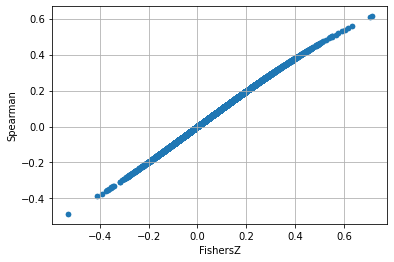

In [24]:
Q.plot.scatter(x='FishersZ',y='Spearman')
plt.grid()

In [25]:
G = pd.DataFrame(columns = ['Participant_Code','Event_Type','Event','Event1','Correlations'])
evs = Q['Event1'].unique()
k=0
for ev in evs:
    F = Q.query('Event1==@ev')
    parts = F['index'].unique()
    for partID in parts:
        E = F.query('index==@partID')
        row = E.iloc[0,:]
        G.loc[k,'Participant_Code'] = partID
        G.loc[k,'Event_Type'] = row['Event_Type']
        G.loc[k,'Event1'] = row['Event1']
        G.loc[k,'Event'] = row['Event']
        G.loc[k,'Correlations'] = np.tanh(E['FishersZ'].mean())
        k+=1

evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
for ev in evord:
    G.loc[G['Event1'].str.startswith(ev[:4]),'Sections1'] = ev
G.loc[:5,:]

,Participant_Code,Event_Type,Event,Event1,Correlations,Sections1
0,ADQ003,Speech,Speech,Speech 1,0.002865,Speech
1,ADQ004,Speech,Speech,Speech 1,0.034052,Speech
2,ADQ005,Speech,Speech,Speech 1,0.045655,Speech
3,ADQ006,Speech,Speech,Speech 1,0.020167,Speech
4,ADQ007,Speech,Speech,Speech 1,-0.003758,Speech
5,ADQ008,Speech,Speech,Speech 1,0.009253,Speech


In [26]:
G.to_csv('./outdata/QoM_meanrho.csv')

Reserve pairwise correlations between participants for near and select relationships.

In [17]:
Sub_Rels = pd.read_csv('./data/Audience/Sub_Relationships_Hall_Rand_Distant.csv', index_col=0)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
909,ADQ003,ADQ008,4.0,0,Stranger
910,ADQ003,ADQ048,4.0,0,Stranger
911,ADQ055,ADQ059,4.0,0,Stranger
912,ADQ043,ADQ060,4.0,0,Stranger


In [28]:
ev = 'Music'
A=Q.copy()

for ev in evord:
    A.loc[A['Event1'].str.startswith(ev[:4]),'Sections'] = ev
A.loc[:,'Relationship'] = ''
A.loc[:,'Familiarity'] = 0
A.loc[:,'Distance'] = np.nan
A.loc[:,'Close'] = 0


for i,rel in Sub_Rels.iterrows():
    p1 = rel["Participant_Code_1"]
    p2 = rel["Participant_Code_2"]
    V = A.query('index==@p1 and Pair==@p2')
    A.loc[V.index,'Relationship']=rel['Relationship']
    A.loc[V.index,'Familiarity']=rel['Familiarity']
    A.loc[V.index,'Distance']=rel['Distance']
    if rel['Distance']<4.0:
        A.loc[V.index,'Close']=1
# C = A.query('Close==1').copy()
# C.to_csv('pairwiseRelsRandDist.csv')
C = A.query('Distance>-3').copy()
C.to_csv('./outdata/pairwiseRelsRandDist.csv')

### Alternative pairwise comparisons for mean rho 

Generate the set of alternatives and truncated thrue correlations for each segment, by comparing to others in the same category of events, looking only at participants who are active for at least 75% of the event interval and only if the alternative segment is at least 40% of the duration of the reference segment.

This threshold, 40% looks low, but it's necessary for the smaller set of segments being evaluated here (60 s), between surveys and clapping intervals and speechs. This however does help restrict comparisons for the music intervals. The last alternative is to estimate the standard deviation reduction of longer intervals and scale alternatives accordingly. Which could work and be mathematically legit, but would probably be a lot to explain in the text. 

In [29]:
res = []
ETypes = ['Music','Survey','Speech','Applause'] #
method = 'spearman'

MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur').reset_index()
for i,r in MTs.iterrows():
    sigs1=hall_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    nanratio1 = sigs1.isna().sum()/len(sigs1)
    sigs1 = sigs1.loc[:,nanratio1<0.25].copy()
    partIDs1 = sigs1.columns
    for j,q in MTs.iterrows():
        if r['Event_Type'] == q['Event_Type']:
            if r['Shorter_tag'] != q['Shorter_tag']:
                sigs2=hall_df.loc[q['Time_s']:q['Time_s']+q['Event_Duration'],:].copy()
                nanratio2 = sigs2.isna().sum()/len(sigs2)
                sigs2 = sigs2.loc[:,nanratio2<0.25].copy()
                partIDs2 = sigs2.columns
                L = np.min([len(sigs1),len(sigs2)])-1
                parts = list(set(partIDs1) & set(partIDs2))
                if L>len(sigs1)*0.4: # one instance from the shorter survey at 0.5 exactly
                    corr1 = pd.concat([sigs1.loc[:,parts].iloc[:L,:].reset_index(drop=True),sigs2.loc[:,parts].iloc[:L,:].reset_index(drop=True)],axis=1).corr(method='spearman')
                    corr2 = corr1.iloc[len(parts):,:len(parts)].reset_index(drop=False).copy().rename(columns={"index": "PartID"})
                    K = pd.melt(corr2, id_vars=['PartID'], value_vars=parts,var_name='PairID', value_name='Spearman_alt')
                    K['Event_Type']= r['Event_Type']
                    K['Event1']=r['Shorter_tag']
                    K['Event2']=q['Shorter_tag']
                    # within event signal corr of the same duration on the true set
                    corr3 = pd.concat([sigs1.loc[:,parts].iloc[:L,:].reset_index(drop=True),sigs1.loc[:,parts].iloc[:L,:].reset_index(drop=True)],axis=1).corr(method='spearman')
                    corr4 = corr3.iloc[len(parts):,:len(parts)].reset_index(drop=False).copy().rename(columns={"index": "PartID"})
                    Ktrue = pd.melt(corr4, id_vars=['PartID'], value_vars=parts,var_name='PairID', value_name='Spearman_true')
                    K['Spearman_true'] = Ktrue['Spearman_true'] 
                    res.append(K.query('PartID!=PairID')) #skip identity match in alt and in true 

R = pd.concat(res, axis=0)
R = R.reset_index(drop=True)
Qalt = R.loc[R['Spearman_alt'].notna(),:].copy()
Qalt = Qalt.loc[Qalt['Spearman_true'].notna(),:].copy()

Qalt['FishersZ_alt'] =np.arctanh(Qalt['Spearman_alt'])
Qalt['FishersZ_true'] =np.arctanh(Qalt['Spearman_true'])

Qalt.loc[:5,:] 

,PartID,PairID,Spearman_alt,Event_Type,Event1,Event2,Spearman_true,FishersZ_alt,FishersZ_true
0,ADQ040,ADQ048,0.086730,Speech,Speech 1,Speech 2,-0.058527,0.086949,-0.058594
1,ADQ038,ADQ048,-0.137162,Speech,Speech 1,Speech 2,-0.062296,-0.138032,-0.062377
2,AER090,ADQ048,-0.038846,Speech,Speech 1,Speech 2,0.050226,-0.038866,0.050268
3,ADR069,ADQ048,-0.017016,Speech,Speech 1,Speech 2,0.027949,-0.017017,0.027957
4,ADQ004,ADQ048,0.028276,Speech,Speech 1,Speech 2,0.143608,0.028283,0.144608
5,ADQ062,ADQ048,-0.038782,Speech,Speech 1,Speech 2,-0.032621,-0.038802,-0.032632


In [30]:
Qalt.to_csv('./outdata/Paired_alts_full.csv')

An example of the measurements alternatives  

In [31]:
evs = Qalt['Event1'].unique()
ev1 = 'Claps 5'
ev2 = 'Claps 14'
D = Qalt.query('Event1==@ev1') # 9650 
F = D.query('Event2==@ev2') # 9650 rows × 7 columns same because they are the same length
F

,PartID,PairID,Spearman_alt,Event_Type,Event1,Event2,Spearman_true,FishersZ_alt,FishersZ_true
495980,ADQ040,ADQ048,-0.064060,Applause,Claps 5,Claps 14,0.107648,-0.064148,0.108066
495981,ADQ038,ADQ048,-0.045388,Applause,Claps 5,Claps 14,0.189548,-0.045419,0.191868
495982,AER090,ADQ048,0.007702,Applause,Claps 5,Claps 14,0.065845,0.007702,0.065940
495983,ADQ004,ADQ048,-0.116939,Applause,Claps 5,Claps 14,0.057653,-0.117477,0.057717
495984,ADR069,ADQ048,-0.031092,Applause,Claps 5,Claps 14,0.162870,-0.031102,0.164333
...,...,...,...,...,...,...,...,...,...
499397,ADQ024,ADQ034,0.087003,Applause,Claps 5,Claps 14,0.076165,0.087223,0.076313
499398,AEQ082,ADQ034,-0.071134,Applause,Claps 5,Claps 14,0.139178,-0.071254,0.140088
499399,AEQ088,ADQ034,-0.059013,Applause,Claps 5,Claps 14,0.116214,-0.059081,0.116741
499400,ADQ047,ADQ034,0.030138,Applause,Claps 5,Claps 14,0.094778,0.030147,0.095063


In [32]:
Galt = pd.DataFrame(columns = ['Participant_Code','Event_Type','Event1','Event2','Correlations_alt','Correlations_true'])
evs = list(set(Qalt['Event1'].unique()) & set(Qalt['Event2'].unique())) + list(set(Qalt['Event1'].unique()) ^ set(Qalt['Event2'].unique()))
k=0
for ev1 in evs:
    D = Qalt.query('Event1==@ev1')
    for ev2 in evs:
        F = D.query('Event2==@ev2')
        parts = F['PartID'].unique()
        for partID in parts:
            E = F.query('PartID==@partID')
            row = E.iloc[0,:]
            Galt.loc[k,'Participant_Code'] = partID
            Galt.loc[k,'Event_Type'] = row['Event_Type']
            Galt.loc[k,'Event1'] = row['Event1']
            Galt.loc[k,'Event2'] = row['Event2']
            Galt.loc[k,'Correlations_alt'] = np.tanh(E['FishersZ_alt'].mean())
            Galt.loc[k,'Correlations_true'] = np.tanh(E['FishersZ_true'].mean())
            k+=1
Galt.iloc[:5,:]


,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true
0,ADQ040,Music,Folk 5,Schnit. 2,-0.001882,-0.002266
1,ADQ038,Music,Folk 5,Schnit. 2,-0.001773,0.008837
2,AER090,Music,Folk 5,Schnit. 2,0.000607,0.013267
3,ADQ004,Music,Folk 5,Schnit. 2,0.012167,0.01514
4,ADR069,Music,Folk 5,Schnit. 2,0.000002,-0.003744


In [33]:
# check for redudancies
Galt.query('Event1=="Claps 5" and Event2=="Claps 14" and Participant_Code=="ADQ009"')

,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true
2947,ADQ009,Applause,Claps 5,Claps 14,0.019079,0.121204


In [35]:
# check for redudancies
Galt.query('Event1=="Claps 5" and Event2=="Claps 14" and Participant_Code=="ADQ009"')

,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true
12702,ADQ009,Applause,Claps 5,Claps 14,0.019108,0.118052


In [34]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']
Galt['Sections1'] = ''
Galt['Sections2'] = ''
for ev in evord:
    Galt.loc[Galt['Event1'].str.startswith(ev[:4]),'Sections1'] = ev
    Galt.loc[Galt['Event2'].str.startswith(ev[:4]),'Sections2'] = ev
Galt.iloc[:5,:]

,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true,Sections1,Sections2
0,ADQ040,Music,Folk 5,Schnit. 2,-0.001882,-0.002266,Folk,Schnittke
1,ADQ038,Music,Folk 5,Schnit. 2,-0.001773,0.008837,Folk,Schnittke
2,AER090,Music,Folk 5,Schnit. 2,0.000607,0.013267,Folk,Schnittke
3,ADQ004,Music,Folk 5,Schnit. 2,0.012167,0.01514,Folk,Schnittke
4,ADR069,Music,Folk 5,Schnit. 2,0.000002,-0.003744,Folk,Schnittke


In [35]:
Galt.to_csv('./outdata/altQoM_pairwise_narrowed40p_truedur.csv')

From the original pairings, tag the pairings that will be used for the spatial and relationships analysis to follow and save the results

In [20]:
G= pd.read_csv('./outdata/QoM_meanrho.csv',index_col=0)

Galt= pd.read_csv('./outdata/altQoM_pairwise_narrowed40p_truedur.csv',index_col=0)
Galt['Correlations_alt'] = Galt['Correlations_alt'].astype('float')
Galt['Correlations_true'] = Galt['Correlations_true'].astype('float')


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/bayesian.py:154: RuntimeWarning: overflow encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


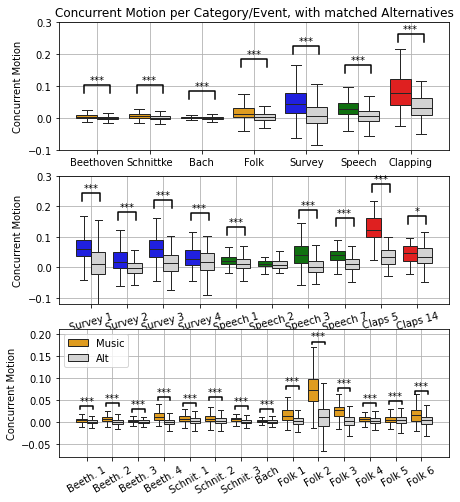

In [21]:
fig, axes= plt.subplots(3,1,figsize=(7, 8))

ax = axes[0]
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']
for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs_alt['Correlations'] =MeanCorrs_alt['Correlations_alt'] 
    MeanCorrs = Galt.query('Event_Type==@ets').copy()
    MeanCorrs['Correlations'] = MeanCorrs['Correlations_true'] 
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Sections1', y='Correlations', order = evord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False,ax=ax)
ax.grid()

for i in range(len(evord)):
    ev = evord[i]
    Gset = Galt.query('Sections1==@ev')
    C = Gset['Correlations_true'].astype('float').quantile(0.97)
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(evord),0.5)-0.25,np.ones(len(evord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_ylim([-0.1,0.3])
ax.set_xticks(np.arange(len(evord)),evord,rotation=0)

#
ax  = axes[1]

ETypes = ['Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
musord = ['Survey 1','Survey 2','Survey 3','Survey 4','Speech 1', 'Speech 2', 'Speech 3', 'Speech 7','Claps 5','Claps 14']
for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs_alt['Correlations'] =MeanCorrs_alt['Correlations_alt'] 
    MeanCorrs = Galt.query('Event_Type==@ets').copy()
    MeanCorrs['Correlations'] = MeanCorrs['Correlations_true'] 
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False, ax=ax)

for i in range(len(musord)):
    ev = musord[i]
    Gset = Galt.query('Event1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    C = Gset['Correlations_true'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_ylim([-0.12,0.3])
ax.set_xticks(np.arange(len(musord)),musord,rotation=15)
ax.grid()

#
ax = axes[2]
ets = 'Music'
MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
MeanCorrs_alt['Type'] = 'Alt'
MeanCorrs_alt['Correlations'] = MeanCorrs_alt['Correlations_alt'] 
MeanCorrs = Galt.query('Event_Type==@ets').copy()
MeanCorrs['Correlations'] = MeanCorrs['Correlations_true'] 
MeanCorrs['Type'] = ets
MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
musord=G.query('Event_Type=="Music"')['Event1'].unique()
sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue = 'Type', hue_order=['Music','Alt'], 
               showfliers = False, palette=events_palette, ax=ax)
for i in range(len(musord)):
    ev = musord[i]
    Gset = Galt.query('Event1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    C = Gset['Correlations_true'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.legend(loc='upper left')
ax.set_ylim([-0.08,0.21])
ax.set_xticks(np.arange(len(musord)),musord,rotation=30)
ax.grid()
axes[0].set_title('Concurrent Motion per Category/Event, with matched Alternatives')
plt.savefig('./plots/Figure_Corrs_Alt_durTur.png', bbox_inches = 'tight',dpi = 196)

plt.show()

In [22]:
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']
ttest_set = pd.DataFrame(index = evord,columns = ['True_rho','Alt_rho','T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for i in range(len(evord)):
    ev = evord[i]
    Gset = Galt.query('Sections1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    pval = ac['p-val'].values[0]
    print([ev,Gset['Correlations_true'].mean(),Gset['Correlations_alt'].mean()])
    print(ac)
    ac['True_rho'] = np.round(Gset['Correlations_true'].mean(),4)
    ac['Alt_rho'] = np.round(Gset['Correlations_alt'].mean(),4)
    ttest_set.loc[ev,:] = ac.loc['T-test']
ttest_set.round(4).to_csv('./outdata/t-tests/Coherence_event_cat_ttest_stats.csv')

['Beethoven', 0.006594413965121802, 0.0002800826733071942]
                T   dof alternative          p-val        CI95%  cohen-d  \
T-test  31.743361  3604     greater  1.625233e-195  [0.01, inf]  0.75646   

              BF10  power  
T-test  2.383e+191    1.0  
['Schnittke', 0.00723710959249099, 0.0024386658703345293]
                T   dof alternative         p-val       CI95%   cohen-d  \
T-test  18.717502  2547     greater  1.191207e-73  [0.0, inf]  0.513066   

             BF10  power  
T-test  7.116e+69    1.0  
['Bach', 0.002273976936158467, 0.000987291641759391]
               T  dof alternative         p-val       CI95%   cohen-d  \
T-test  4.939275  581     greater  5.132849e-07  [0.0, inf]  0.289435   

            BF10  power  
T-test  1.36e+04    1.0  
['Folk', 0.02340553736984693, 0.004056206930014346]
                T   dof alternative  p-val        CI95%   cohen-d BF10  power
T-test  40.704399  5388     greater    0.0  [0.02, inf]  0.742648  inf    1.0
['Survey'

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/bayesian.py:154: RuntimeWarning: overflow encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


In [24]:
print(ttest_set.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & True_rho & Alt_rho & T & dof & alternative & p-val & CI95% & cohen-d & BF10 & power \\
\midrule
Beethoven & 0.006600 & 0.000300 & 31.743361 & 3604 & greater & 0.000000 & [0.01  inf] & 0.756460 & 2.383e+191 & 1.000000 \\
Schnittke & 0.007200 & 0.002400 & 18.717502 & 2547 & greater & 0.000000 & [ 0. inf] & 0.513066 & 7.116e+69 & 1.000000 \\
Bach & 0.002300 & 0.001000 & 4.939275 & 581 & greater & 0.000001 & [ 0. inf] & 0.289435 & 1.36e+04 & 1.000000 \\
Folk & 0.023400 & 0.004100 & 40.704399 & 5388 & greater & 0.000000 & [0.02  inf] & 0.742648 & inf & 1.000000 \\
Survey & 0.048900 & 0.010500 & 16.044774 & 575 & greater & 0.000000 & [0.03  inf] & 0.859031 & 9.4e+44 & 1.000000 \\
Speech & 0.030500 & 0.007000 & 15.073067 & 689 & greater & 0.000000 & [0.02  inf] & 0.823790 & 2.602e+41 & 1.000000 \\
Clapping & 0.084500 & 0.034500 & 8.705587 & 117 & greater & 0.000000 & [0.04  inf] & 1.066058 & 5.748e+11 & 1.000000 \\
\bottomrule
\end{tabular}



In [25]:
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
musord = ['Survey 1','Survey 2','Survey 3','Survey 4','Speech 1', 'Speech 2', 'Speech 3', 'Speech 7','Claps 5','Claps 14']
ttest_set = pd.DataFrame(index = musord,columns = ['True_rho','Alt_rho','T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for i in range(len(musord)):
    ev = musord[i]
    Gset = Galt.query('Event1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    pval = ac['p-val'].values[0]
    print([ev,Gset['Correlations_true'].mean(),Gset['Correlations_alt'].mean()])
    print(ac)
    ac['True_rho'] = np.round(Gset['Correlations_true'].mean(),4)
    ac['Alt_rho'] = np.round(Gset['Correlations_alt'].mean(),4)
    ttest_set.loc[ev,:] = ac.loc['T-test']
musord=[ 'Beeth. 1',  'Beeth. 2', 'Beeth. 3', 'Beeth. 4','Schnit. 1','Schnit. 2',
        'Schnit. 3', 'Bach', 'Folk 1', 'Folk 2','Folk 3', 'Folk 4','Folk 5', 'Folk 6', ]  
for i in range(len(musord)):
    ev = musord[i]
    Gset = Galt.query('Event1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    print([ev,Gset['Correlations_true'].mean(),Gset['Correlations_alt'].mean()])
    print(ac)
    ac['True_rho'] = np.round(Gset['Correlations_true'].mean(),4)
    ac['Alt_rho'] = np.round(Gset['Correlations_alt'].mean(),4)
    ttest_set.loc[ev,:] = ac.loc['T-test']
ttest_set.to_csv('./outdata/t-tests/Coherence_events_ttest_stats.csv')

['Survey 1', 0.0689661011567307, 0.015330272698954244]
                T  dof alternative         p-val        CI95%   cohen-d  \
T-test  10.567825  164     greater  1.546620e-20  [0.05, inf]  1.023025   

             BF10  power  
T-test  3.053e+17    1.0  
['Survey 2', 0.02332614623659677, -0.0035005517524845315]
               T  dof alternative         p-val        CI95%   cohen-d  \
T-test  5.976518  124     greater  1.125592e-08  [0.02, inf]  0.801105   

             BF10  power  
T-test  9.574e+05    1.0  
['Survey 3', 0.060782247635429366, 0.01295887011083028]
                T  dof alternative         p-val        CI95%   cohen-d  \
T-test  11.027237  164     greater  8.313941e-22  [0.04, inf]  1.153306   

            BF10  power  
T-test  5.37e+18    1.0  
['Survey 4', 0.0318213529118757, 0.014931752022426652]
               T  dof alternative     p-val        CI95%   cohen-d     BF10  \
T-test  4.019113  120     greater  0.000051  [0.01, inf]  0.462688  335.803   

      

In [28]:
print(ttest_set.to_latex(index=False))

\begin{tabular}{llllllllll}
\toprule
True_rho & Alt_rho & T & dof & alternative & p-val & CI95% & cohen-d & BF10 & power \\
\midrule
0.069000 & 0.015300 & 10.567825 & 164 & greater & 0.000000 & [0.05  inf] & 1.023025 & 3.053e+17 & 1.000000 \\
0.023300 & -0.003500 & 5.976518 & 124 & greater & 0.000000 & [0.02  inf] & 0.801105 & 9.574e+05 & 1.000000 \\
0.060800 & 0.013000 & 11.027237 & 164 & greater & 0.000000 & [0.04  inf] & 1.153306 & 5.37e+18 & 1.000000 \\
0.031800 & 0.014900 & 4.019113 & 120 & greater & 0.000051 & [0.01  inf] & 0.462688 & 335.803 & 0.999682 \\
0.021100 & 0.011200 & 5.011373 & 215 & greater & 0.000001 & [0.01  inf] & 0.465337 & 1.889e+04 & 1.000000 \\
0.010600 & 0.009400 & 0.456356 & 63 & greater & 0.324852 & [-0. inf] & 0.074956 & 0.303 & 0.146486 \\
0.040800 & 0.000700 & 11.728083 & 216 & greater & 0.000000 & [0.03  inf] & 1.154215 & 1.123e+22 & 1.000000 \\
0.036200 & 0.008600 & 10.237644 & 192 & greater & 0.000000 & [0.02  inf] & 1.000768 & 1.41e+17 & 1.000000 \\
0

Now plot and mark the t-test comparisons between the correlations between participants, true and null/alternative, evaluating which intervals of the concert showed shared patterns of motion. 

In [543]:
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']

for i in range(len(evord)):
    ev = evord[i]
    ac = pg.ttest(G.loc[G['Sections1']==ev,'Correlations'],Galt.loc[Galt['Sections1']==ev,'Correlations'],alternative='greater')
    C = G.loc[G['Sections1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    print([ev,G.loc[G['Sections1']==ev,'Correlations'].mean()])
    print(ac)

['Beethoven', 0.007299365068562629]
                T         dof alternative         p-val        CI95%  \
T-test  13.901524  340.105642     greater  2.107933e-35  [0.01, inf]   

         cohen-d       BF10  power  
T-test  1.050871  1.653e+40    1.0  
['Schnittke', 0.0076040113456556846]
               T         dof alternative         p-val       CI95%   cohen-d  \
T-test  5.689736  272.474916     greater  1.640063e-08  [0.0, inf]  0.361858   

             BF10    power  
T-test  1.176e+06  0.99988  
['Bach', 0.002786081656546847]
              T         dof alternative     p-val       CI95%   cohen-d  \
T-test  1.67154  150.640359     greater  0.048345  [0.0, inf]  0.161263   

         BF10     power  
T-test  1.026  0.361831  
['Folk', 0.024013518150553876]
                T         dof alternative         p-val        CI95%  \
T-test  12.875577  469.489731     greater  5.301527e-33  [0.02, inf]   

         cohen-d       BF10  power  
T-test  1.003207  1.777e+34    1.0  
['Sur

## Cross audience mean rho against ratings 

This analysis is a bit wonky because meanrho is not a good measure of concurrent motion between pieces, specifically the effect of duration and the total quantity of motion. At best it should replicated the Folk/classical difference. But it's worth checking to conform the relationship.



There is no robust relationship between mean rho and body awareness or judgements of own motion during classical pieces, like with average quantity of motion. During classical music, the shared patterns of motion are not a product of or conditional on self-awareness. 

The lack of distinction for own motion judgments over classical and folk conditions reinforces this disconnect. How well people moved with each other is not result of conscious control and active voluntary motion. That isn't to say no moments of concurrent motion were under audience members control or awareness, but these were not persistent conditions that differentiated participants coordination with the music/whole audience.

In [43]:
ETypes = ['Music']
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk']

for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs = G.query('Event_Type==@ets').copy()
    MeanCorrs['Type'] = ets

In [44]:
partID = 'ADQ003'
music='Beethoven'
MeanCorrs.query('Participant_Code==@partID and Sections1==@music').loc[:,'Correlations'].max()

0.015904172312011453

In [53]:
mm_df = pd.read_csv('./data/Audience/Participants_Pieces_motion_judgements.csv')
Quest_text = pd.read_csv(public_Part + 'Surveys_Codebook.csv', delimiter=",", encoding='latin-1')


In [54]:
parts = MeanCorrs['Participant_Code'].unique()
df = mm_df.query("ParticipantCode in @parts").copy()
df['meanmeanrho'] = np.nan
df['maxmeanrho'] = np.nan

for i, row in df.iterrows():
    partID = row['ParticipantCode']
    music = row['Music']
    rhos = MeanCorrs.query('Participant_Code==@partID and Sections1==@music').loc[:,'Correlations']
    if len(rhos)>0:
        df.loc[i,'meanmeanrho'] = rhos.mean()
        df.loc[i,'maxmeanrho'] = rhos.max()


In [55]:
CORRED = df.loc[~df['meanmeanrho'].isna(),:].copy().reset_index(drop=True)
sub_H = CORRED.copy()

In [56]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body_Bach', 'aware_movement_Bach', 'aware_others_moving_Bach', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']

sub_text = Quest_text.loc[Quest_text['ID'].isin(sub_Q_List),:]
sub_text.set_index('ID',drop=True,inplace = True)
# sub_text

In [57]:
tag_Q = 'aware_body'
tag_m = 'meanmeanrho' #'mQoM''meanmeanrho' 
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)

Were you aware of your physical body during this piece?


Were you aware of your physical body during this piece?
       Source  ddof1     ddof2         F     p-unc       np2
0  aware_body      3  88.06946  3.277284  0.024722  0.045958
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.015916  0.009621  0.006294  0.002490   
1    Continuously      Not at all  0.015916  0.007016  0.008900  0.002842   
2    Continuously          Rarely  0.015916  0.010186  0.005729  0.002602   
3  Intermittently      Not at all  0.009621  0.007016  0.002605  0.001773   
4  Intermittently          Rarely  0.009621  0.010186 -0.000565  0.001355   
5      Not at all          Rarely  0.007016  0.010186 -0.003170  0.001927   

          T          df      pval    hedges  
0  2.528137   49.439886  0.067815  0.558717  
1  3.131507   65.256349  0.013537  0.686788  
2  2.201953   57.835115  0.134850  0.478618  
3  1.469693   43.385766  0.464177  0.265134  
4 -0.416938  164.953532  0.975516 -0.056461  
5 -1.6

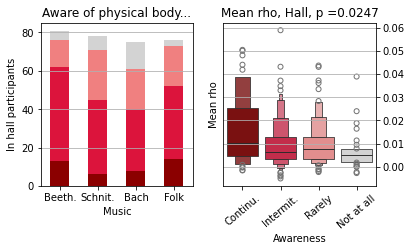

In [58]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(tracks_tag)
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
# fig.legend(loc='center right',ncol=3,fontsize = 8)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED)
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED))

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = CORRED, ax = ax2)
ax2.set_xticks([0,1,2,3])
# ax2.set_xticklabels(short_responses,labelrotation='20')
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_xlabel('Awareness')
ax2.set_ylabel('Mean rho')
ax2.set_title('Mean rho, Hall, p =' + str(aov['p-unc'].values[0].round(4)))
ax2.yaxis.tick_right()
# ax2.set_ylim([0,1.5])
ax2.grid(axis='y')

# plt.savefig('./plots/body_aware_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
#fig.legend(labels = feats, loc='center right', ncol=3,fontsize = 8)

plt.show()

Aware of physical body...
       Source  ddof1      ddof2        F     p-unc       np2
0  aware_body      3  65.186872  1.19988  0.316847  0.018178
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.007163  0.005570  0.001593  0.001295   
1    Continuously      Not at all  0.007163  0.005147  0.002016  0.001578   
2    Continuously          Rarely  0.007163  0.006753  0.000410  0.001420   
3  Intermittently      Not at all  0.005570  0.005147  0.000423  0.001078   
4  Intermittently          Rarely  0.005570  0.006753 -0.001183  0.000830   
5      Not at all          Rarely  0.005147  0.006753 -0.001606  0.001225   

          T          df      pval    hedges  
0  1.230299   32.300848  0.612599  0.320389  
1  1.277604   49.279409  0.581314  0.344369  
2  0.289013   44.560080  0.991473  0.069634  
3  0.392294   34.391392  0.979183  0.090174  
4 -1.425787  101.804601  0.486328 -0.238290  
5 -1.310403   51.899341  0.560605 -0

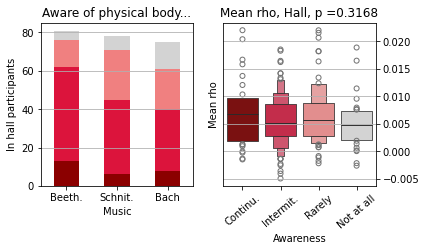

In [59]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach']
tracks_tag = ['Beeth.','Schnit.','Bach']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(tracks_tag)
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks')))

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = CORRED.query('Music in @tracks'), ax = ax2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_xlabel('Awareness')
ax2.set_ylabel('Mean rho')
ax2.set_title('Mean rho, Hall, p =' + str(aov['p-unc'].values[0].round(4)))
ax2.yaxis.tick_right()
ax2.grid(axis='y')

plt.show()

In [60]:
aov['p-unc'].values[0].round(4)

0.3168

In [61]:
tag_Q = 'aware_movement'
# tag_m = 'meanmeanrho'
tag_m = 'maxmeanrho'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)
QuT = 'Relative to your own usual behaviour...' 


Were you aware of your own physical movement during this piece? If so, how much did you move relative to your own usual behaviour at this kind of concert?


           Source  ddof1       ddof2          F     p-unc       np2
0  aware_movement      3  127.385981  10.771468  0.000002  0.144889
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.018931   
1            Not aware of movement  Yes and I moved less than usual  0.018931   
2            Not aware of movement  Yes and I moved more than usual  0.018931   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.025366   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.025366   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.016166   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.025366 -0.006434  0.004811 -1.337316  100.189697  0.541547 -0.217366  
1  0.016166  0.002765  0.004742  0.583220   93.291518  0.936906  0.106210  
2  0.054094 -0.035163  0.007496 -4.690764   81.219444  0.000063 -0.9

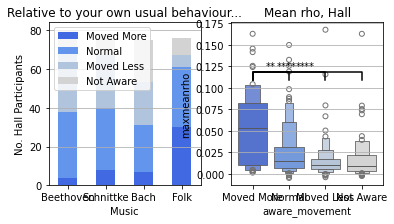

In [64]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = CORRED.query('Music in @tracks'), ax = ax2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses)

print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks')))

ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [0.1,0.1,0.1,0.1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_title('Mean rho, Hall')
# ax2.set_ylim([0,0.07])
ax2.grid(axis='y')
# plt.savefig('./plots/body_move_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()


Relative to your own usual behaviour...
           Source  ddof1     ddof2         F     p-unc       np2
0  aware_movement      3  68.56426  0.757572  0.521774  0.010483
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.009626   
1            Not aware of movement  Yes and I moved less than usual  0.009626   
2            Not aware of movement  Yes and I moved more than usual  0.009626   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.012407   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.012407   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.011026   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.012407 -0.002781  0.001875 -1.483383   84.038952  0.452009 -0.271829  
1  0.011026 -0.001400  0.001850 -0.756890   80.126780  0.873454 -0.145396  
2  0.011217 -0.001591  0.002808 -0

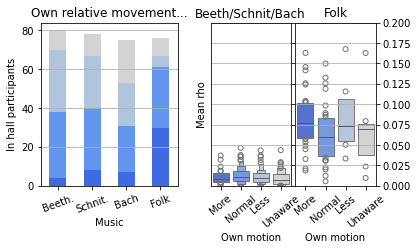

In [65]:
print(QuT)
QuT = 'Own relative movement...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['More','Normal','Less','Unaware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

fig = plt.figure(figsize=(6,3))
gridspec.GridSpec(1,4)

# large subplot
ax1 = plt.subplot2grid((1,12), (0,0), colspan=5, rowspan=1)

#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1,legend=False)
#ax1.legend(loc="best")
ax1.grid(axis='y')
#ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticklabels(tracks_tag,rotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')

tracks = ['Beethoven','Schnittke','Bach',]
aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)
ax2 = plt.subplot2grid((1,12), (0,6), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data=CORRED.query('Music in @tracks'), ax = ax2)
#ax2.set_title('Mean QoM, Hall, p>.3')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_ylim([0,0.2])
ax2.yaxis.tick_right()
ax2.set_yticklabels([])
ax2.set_ylabel('Mean rho')

ax2.set_xlabel('Own motion')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_title('Beeth/Schnit/Bach')
ax2.grid(axis='y')

tracks = ['Folk']
aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)
ax3 = plt.subplot2grid((1,12), (0,9), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data=CORRED.query('Music in @tracks'), ax = ax3)
#ax3.set_title('Mean QoM, Hall, p<.05')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1.2,1.1,1.0,0.9], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(short_responses,rotation=40)
ax3.set_ylim([0,0.2])
ax3.set_ylabel('')
ax3.set_xlabel('Own motion')
ax3.yaxis.tick_right()
ax3.set_title('Folk')
ax3.grid(axis='y')
# plt.savefig('./Plots/body_move_A_R_qom_less.png',bbox_inches = 'tight',dpi = 196)

plt.show()



This analysis is shared for accountability but not actually exposing of anything new or contrary to the information generated from simpler analyses on the average QoM, so it can just stay here. 